In [1]:
### Essential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
### Tools
import warnings
import gc
from tqdm import tqdm
from joblib import dump, load
### ML
import sklearn 
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import KFold
## Config
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
pd.options.plotting.backend = "plotly"
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', font_scale=1.4)
sns.set_palette('crest')
px.defaults.color_continuous_scale='blugrn'


In [82]:
engagement = pd.read_csv("../data/train/engagement.csv")

In [28]:
attribution = pd.read_csv("../data/train/attribution.csv")
network_metric = pd.read_csv("../data/train/network_metrics.csv")
revenue = pd.read_csv("../data/train/revenue.csv")
target = pd.read_csv("../data/train/target.csv")

In [29]:
attribution.install_dt = pd.to_datetime(attribution.install_dt)
attribution.head()

,user_id,install_dt,country,platform,source,device_brand,device_model
0,UID_19600,2022-01-31 02:14:33.905000+00:00,COUNTRY_15,android,SOURCE_69,BRAND_1,MODEL_1
1,UID_19601,2022-01-31 13:12:48.074000+00:00,COUNTRY_74,android,SOURCE_69,BRAND_2,MODEL_2
2,UID_19602,2022-01-31 12:17:32.651000+00:00,COUNTRY_86,android,SOURCE_69,BRAND_3,MODEL_3
3,UID_19603,2022-01-31 17:06:22.888000+00:00,COUNTRY_100,android,SOURCE_69,BRAND_4,MODEL_4
4,UID_19604,2022-01-31 08:07:42.432000+00:00,COUNTRY_19,ios,SOURCE_69,BRAND_5,MODEL_5


In [35]:
def show_top(data,col,n_show=15):
    top = data[col].value_counts().iloc[:n_show]
    fig = top.plot.bar(color=top).update_layout(yaxis_title="Count")
    fig.show()

def show_top_and_compress(data,col, n_show=15,n_compress=None):
    if n_compress==None:
        n_compress=n_show
    show_top(data,col,n_show)
    data[col] = data[col].apply(lambda val: val if val in top[:n_compress].index else 'NOT_COMMON')
    show_top(data,col,n_show)

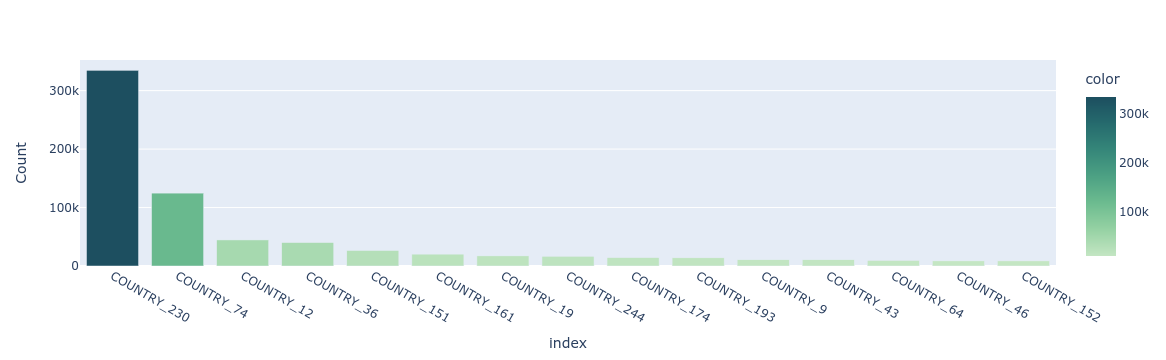

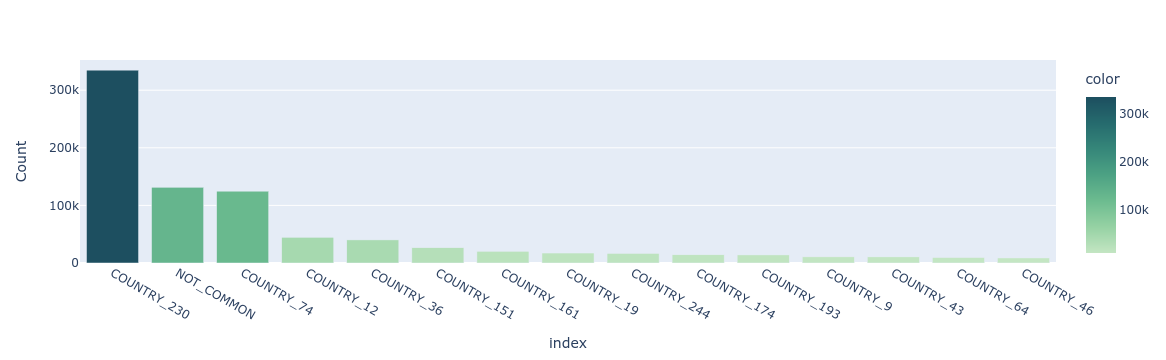

In [31]:
show_top_and_compress(attribution,'country',n_show=15,n_compress=20)

<AxesSubplot:xlabel='platform', ylabel='count'>

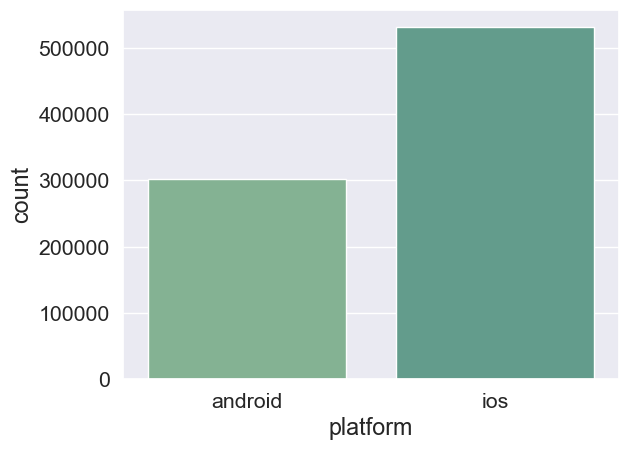

In [21]:
sns.countplot(data=attribution,x='platform')

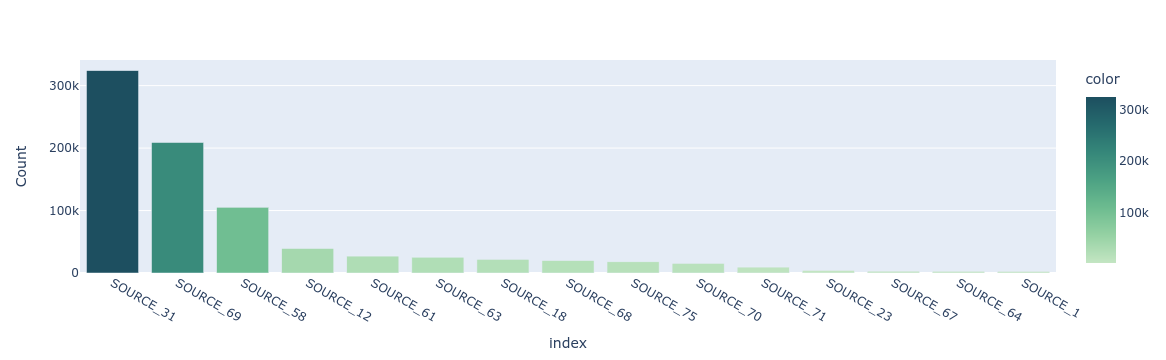

In [39]:
show_top(attribution,'source')

In [24]:
print(f' Unique brands: {len(attribution.device_brand.unique())}, Unique device models:{len(attribution.device_model.unique())}')

 Unique brands: 344, Unique device models:3650


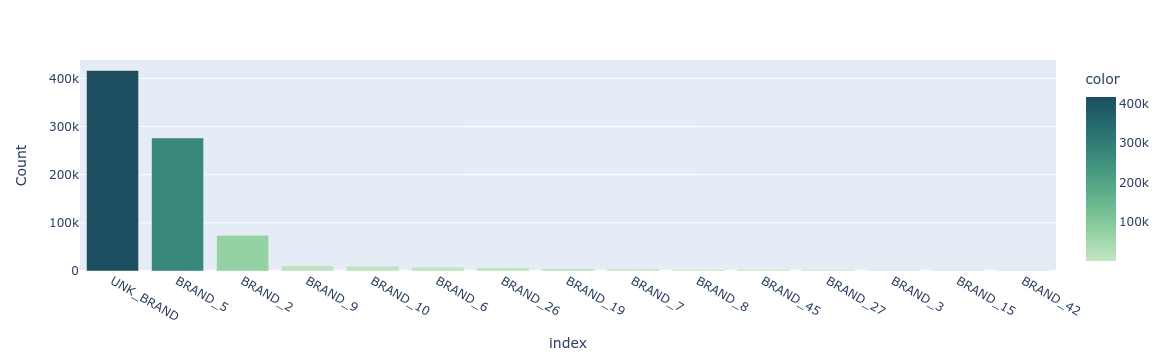

In [36]:
show_top(attribution,'device_brand')

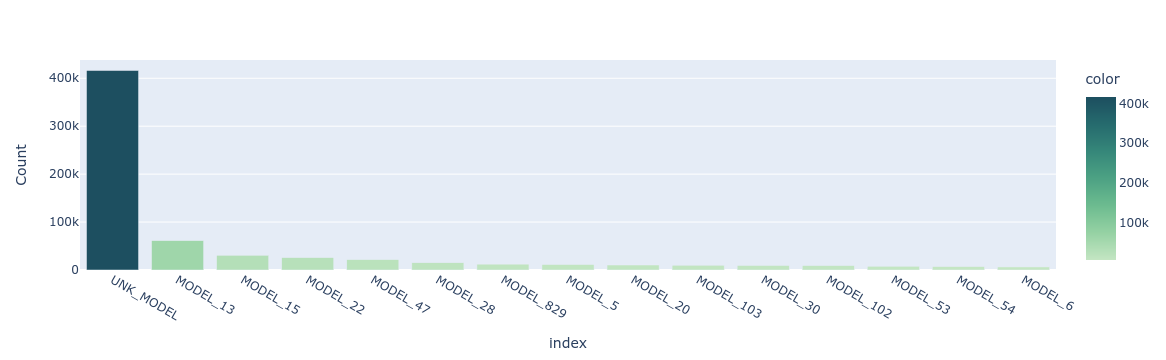

In [38]:
show_top(attribution,'device_model')

Device model and brand may be useful but I don't have enough time to deal with them. Drop

In [41]:
attribution.drop(columns=['device_brand','device_model'],inplace=True)

In [49]:
attribution['days_since_install']=(attribution.install_dt - attribution.install_dt.min()).dt.days
attribution.drop(columns=['install_dt'],inplace=True)

In [83]:
engagement.head()

,date,user_id,vippass_offer_seen_times_today,total_offer_seen_times_today,tickets_spent_today,spinner_seen_times_today,shop_seen_times_today,sessions_time_today,sessions_amount_today,rewarded_ads_shown_today,premium_clothes_today,premium_choices_today,offer_list_seen_times_today,no_ads_offer_seen_times_today,interstitial_ads_shown_today,in_app_seen_times_today,frs_opened_today,diamonds_spent_today,diamonds_collected_with_ads_today,diamonds_collected_by_reading_today,dialogues_shown_today,chapters_unlocked_today,chapters_reread_today,chapters_opened_today,chapters_finished_today,books_reread_today,books_opened_today
0,2022-01-13,UID_244876,0.0000,0.0000,0.0000,0.0000,0.0000,435808220.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2022-01-13,UID_243554,0.0000,0.0000,0.0000,0.0000,0.0000,143068061.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
2,2022-01-13,UID_245294,0.0000,2.0000,0.0000,0.0000,0.0000,1071007000.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,12.0000,0.0000,2.0000,232.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000
3,2022-01-13,UID_235615,3.0000,5.0000,0.0000,0.0000,0.0000,1681003208.0000,2.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,12.0000,0.0000,2.0000,343.0000,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000
4,2022-01-13,UID_243989,0.0000,3.0000,1.0000,0.0000,0.0000,690320999.0000,1.0000,0.0000,1.0000,0.0000,0.0000,2.0000,0.0000,1.0000,0.0000,12.0000,0.0000,2.0000,226.0000,1.0000,0.0000,2.0000,1.0000,0.0000,1.0000


In [84]:
engagement['sessions_time_today'] = engagement['sessions_time_today']/100_000

In [86]:
engagement.drop(columns='date',inplace=True)

In [90]:
total_cols = [col.replace("today","")+'total' if col.find("today")!=-1 else col for col in engagement.columns]

In [91]:
engagement = engagement.groupby(by='user_id').agg('sum').reset_index()

In [93]:
engagement.columns = total_cols
engagement

,user_id,vippass_offer_seen_times_total,total_offer_seen_times_total,tickets_spent_total,spinner_seen_times_total,shop_seen_times_total,sessions_time_total,sessions_amount_total,rewarded_ads_shown_total,premium_clothes_total,premium_choices_total,offer_list_seen_times_total,no_ads_offer_seen_times_total,interstitial_ads_shown_total,in_app_seen_times_total,frs_opened_total,diamonds_spent_total,diamonds_collected_with_ads_total,diamonds_collected_by_reading_total,dialogues_shown_total,chapters_unlocked_total,chapters_reread_total,chapters_opened_total,chapters_finished_total,books_reread_total,books_opened_total
0,UID_100000,0.0000,0.0000,0.0000,0.0000,0.0000,17595.7400,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,84.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
1,UID_100001,0.0000,4.0000,1.0000,0.0000,1.0000,9765.1804,1.0000,0.0000,1.0000,1.0000,0.0000,2.0000,0.0000,1.0000,0.0000,24.0000,0.0000,2.0000,275.0000,1.0000,0.0000,2.0000,1.0000,0.0000,1.0000
2,UID_100002,0.0000,6.0000,1.0000,0.0000,3.0000,37756.6623,4.0000,2.0000,0.0000,2.0000,0.0000,1.0000,0.0000,2.0000,0.0000,24.0000,0.0000,4.0000,881.0000,1.0000,0.0000,5.0000,2.0000,0.0000,4.0000
3,UID_100003,0.0000,0.0000,0.0000,0.0000,0.0000,886.7802,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
4,UID_100004,0.0000,18.0000,3.0000,2.0000,4.0000,27551.0500,2.0000,5.0000,2.0000,4.0000,2.0000,4.0000,0.0000,6.0000,0.0000,77.0000,3.0000,8.0000,937.0000,2.0000,0.0000,4.0000,4.0000,0.0000,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832705,UID_99995,0.0000,0.0000,0.0000,0.0000,0.0000,2116.0900,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
832706,UID_99996,0.0000,0.0000,0.0000,0.0000,0.0000,4360.9600,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,132.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
832707,UID_99997,0.0000,0.0000,0.0000,0.0000,0.0000,5911.6009,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,39.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
832708,UID_99998,0.0000,0.0000,0.0000,0.0000,0.0000,15397.9003,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,140.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000


In [7]:
network_metric.head()

,date,source,country,platform,impressions,clicks,installs,cost
0,2022-01-23,SOURCE_31,COUNTRY_162,ios,5567,1862,56,2.0029
1,2022-01-23,SOURCE_31,COUNTRY_228,ios,97502,34102,953,1186.0345
2,2022-01-23,SOURCE_31,COUNTRY_140,ios,10,6,0,0.0000
3,2022-01-23,SOURCE_31,COUNTRY_127,ios,6,4,0,0.0000
4,2022-01-23,SOURCE_31,COUNTRY_133,ios,1,0,0,0.0000


In [94]:
revenue

,user_id,date,revenue_type,revenue,transaction_count,parcel_name
0,UID_820832,2022-02-08,ad_revenue,0.1837,1.0000,PARCEL_0
1,UID_378100,2022-02-08,ad_revenue,0.1784,1.0000,PARCEL_0
2,UID_1149513,2022-02-08,ad_revenue,0.4093,1.0000,PARCEL_0
3,UID_890088,2022-02-08,subscription_revenue,2.4117,1.0000,PARCEL_1
4,UID_813430,2022-02-08,ad_revenue,0.0396,1.0000,PARCEL_0
...,...,...,...,...,...,...
656537,UID_578549,2022-01-10,inapp_revenue,71.6607,15.0000,PARCEL_3
656538,UID_573631,2022-01-10,inapp_revenue,60.2847,16.0000,PARCEL_3
656539,UID_853715,2022-01-10,inapp_revenue,77.0531,19.0000,PARCEL_3
656540,UID_534638,2022-01-10,inapp_revenue,83.7314,22.0000,PARCEL_3


In [9]:
target.head()

,user_id,revenue
0,UID_100447,2.2013
1,UID_689824,18.2828
2,UID_1134310,1.4012
3,UID_1082945,43.1062
4,UID_915239,0.2792


In [95]:
target

,user_id,revenue
0,UID_100447,2.2013
1,UID_689824,18.2828
2,UID_1134310,1.4012
3,UID_1082945,43.1062
4,UID_915239,0.2792
...,...,...
832999,UID_392517,0.0000
833000,UID_393917,0.0000
833001,UID_394415,0.0000
833002,UID_203848,0.0000


In [97]:
revenue.user_id.unique()

array(['UID_820832', 'UID_378100', 'UID_1149513', ..., 'UID_528929',
       'UID_528891', 'UID_590156'], dtype=object)

In [98]:
print(f'Intersection of revenue dataset and target dataset user_id`s {len(list(set(revenue.user_id) & set(target.user_id)))}')

Intersection of revenue dataset and target dataset user_id`s 210012
